In [1]:
import sympy
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix 
import numpy as np


class RobotEKF(EKF):
    def __init__(self, dt, std_ax, std_ay):
        dim_x = 4
        dim_z = 2
        dim_u = 2
        EKF.__init__(self, dim_x, dim_z, dim_u)

        self.dt = dt
        self.std_ax = std_ax
        self.std_ay = std_ay
        x, y, vx, vy, ax, ay, time = symbols(
        'x, y,  vx, vy, ax, ay, dt')

        self.fxu = Matrix(
            [[x+vx*time],
            [y+vy*time],
            [vx+ax*time],
            [vy+ay*time]])
        self.F_j = self.fxu.jacobian(Matrix([x, y, vx, vy]))
        self.V_j = self.fxu.jacobian(Matrix([ax, ay]))
        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, vx:0, vy:0, 
                     ax:0, ay:0, time:dt}
        self.x_x, self.x_y, = x, y
        self.vx,self.vy, self.ax, self.ay = v, w, ax, ay
        self.time = dt


    def predict(self, u):
        self.subs[self.ax] = u[0]
        self.subs[self.ay] = u[1]
        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)
        # covariance of motion noise in control space
        M = array([[self.std_ax**2, 0],
                    [0, self.std_ay**2]])
        self.P = np.dot(F, self.P).dot(F.T) + np.dot(V, M).dot(V.T)


In [2]:
def H_of(x):
    """ compute Jacobian of H matrix where h(x) computes
    is the measurement"""
    H = array(
    [[1,0,0,0],
     [0,1,0,0]])
    return H

In [3]:
def Hx(x):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    Hx = array([[x[0,0]],
                [x[1,0]]])
    return Hx

In [4]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    return y

In [5]:
"""
TODO: Tune this EKF
"""
from math import atan2
import pandas as pd

dt = 0.1

def ekf_update(ekf, z):
    ekf.update(z, HJacobian=H_of, Hx=Hx,residual = residual)

def run_localization(data, std_ax, std_ay,
                     std_gx, std_gy):
    """
    Parameters:
    data: sensor data in csv in form of a, omega, GPS.x, GPS.y
    """


    ekf = RobotEKF(dt=dt, std_ax=std_ax,std_ay=std_ay)
    ekf.x = array([[0, 0, 0, 0]]).T # x, y, v_x, v_y,
    ekf.P = np.diag([1, 1, 1, 1]) # variance of states
    ekf.R = np.diag([std_gx**2, std_gy**2]) # variance of measurement    
    track = []
    history = []
    prev_row = None
    start = 0
    angle_found = False

    """ 

    ### Find initial angle
    for i , row in data.iterrows():
        if row["GPSx"] == 0:
            first_point = [row["GPSy"],row["GPSx"]]
            continue
        elif first_point[0] != row["GPSy"] or first_point[0] != row["GPSx"]:
             rad = atan2(row["GPSy"]-first_point[0],row["GPSx"]-first_point[1]) """


    find_first = False
    for i , row in data.iterrows():
        ### Skip when GPS is not initiate
        if row["GPSx"] == 0:
            prev_row = row["GPSy"],row["GPSx"]
            continue
        elif not find_first:
            ekf.x = array([[row["GPSx"],row["GPSy"], 0, 0]]).T
            find_first = not find_first

        u = array([row["ax"],row["ay"]]) # input is ax and ay
        z = array([row["GPSx"],row["GPSy"]]) 
        ekf.predict(u=u)

        if i%10 == 0:
            track.append([ekf.x[0,0],ekf.x[1,0],row["GPSx"],row["GPSy"]])
            history.append([ekf.x[i,0] for i in range(4)])
            ekf_update(ekf, z)

    track = np.array(track)
    history = np.array(history)
    return ekf ,track, history

In [11]:
data = pd.read_csv('kalman01.csv')
ekf, track , history = run_localization(data, std_ax = 0.1, std_ay = 0.2,
                     std_gx = 2, std_gy = 2)
print('Final P:', ekf.P.diagonal())

Final P: [0.67523752 0.93526052 0.01101172 0.03089513]


In [7]:
result = pd.DataFrame(track, columns= ['x','y','GPSx','GPSy'])
# result.to_csv('result00.csv')

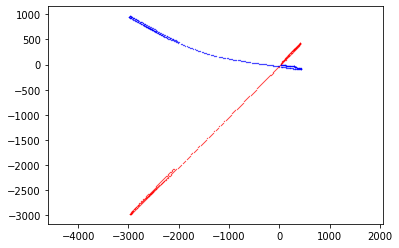

In [8]:
import matplotlib.pyplot as plt
plt.scatter(result['x'],result['y'],s = 0.1,c='r')
plt.scatter(result['GPSx'],result['GPSy'],s = 0.1,c='b')
plt.axis('equal')
plt.show()

In [90]:
history

array([[ 3.87592156e+01, -6.13305678e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.87592156e+01,  3.13045627e+00,  0.00000000e+00,
         1.78179425e+00],
       [ 3.89221475e+01,  1.56996672e+01,  8.78553173e-02,
         8.56613050e+00],
       ...,
       [-2.12564780e+03, -2.09885077e+03, -1.87138025e+02,
        -2.48427992e+02],
       [-2.11001487e+03, -2.08347225e+03, -1.85749878e+02,
        -2.46499358e+02],
       [-2.09461853e+03, -2.06836008e+03, -1.84382739e+02,
        -2.44604126e+02]])

In [91]:
result = pd.DataFrame(history, columns= ['x','y' ,'vx','vy'])
result.to_csv('history00.csv')